In [103]:


import torch
print("PyTorch:", torch.__version__)  # e.g., 2.1.0+cu121
print("CUDA:", torch.version.cuda)    # e.g., 12.1
!python --version   

import torch
import random
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import numpy as np
from datasets import load_dataset



PyTorch: 2.3.0+cu118
CUDA: 11.8
Python 3.11.11


In [104]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import joblib
df = pd.read_csv('/kaggle/input/newwyork/all_stocks_5yr.csv')
# Show the first 5 unique company names
unique_companies = df['Name'].unique()[:6]
print(unique_companies)
    
print("✅ Original Data:")
print(f"📐 Shape: {df.shape}")
print(f"🧾 Columns: {df.columns.tolist()}")
print("\n🔍 Sample Data:")
print(df.head())

# Drop rows with missing values (if any)
df = df.dropna()

# Convert and sort by date
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date').reset_index(drop=True)

aal_df = df[df['Name'] == 'AAL'].copy()
aal_df.set_index('date', inplace=True)  # Set date as index for time-based operations
print(f"AAL Stock Data Shape: {aal_df.shape}")


# Select features and target
feature_cols = ['open', 'high', 'low', 'close', 'volume']
target_col = 'close'

features = aal_df[feature_cols].values.astype(np.float32)
target = aal_df[target_col].values.astype(np.float32)

# Normalize features and target separately
feature_scaler = StandardScaler()
target_scaler = StandardScaler()


scaled_features = feature_scaler.fit_transform(features)
scaled_target = target_scaler.fit_transform(target.reshape(-1, 1))
# Save the scaler for inference
joblib.dump(target_scaler, 'target_scaler.pkl')

# Print scaler stats (verify)
print(f"Original mean: ${target_scaler.mean_[0]:.2f}")
print(f"Original std: ${target_scaler.scale_[0]:.2f}")
# Create sequences with multiple features
def create_sequences(features, target, seq_length, pred_length):
    X, y = [], []
    for i in range(len(features) - seq_length - pred_length + 1):
        X.append(features[i:i+seq_length])  # Shape: (seq_length, num_features)
        y.append(target[i+seq_length:i+seq_length+pred_length])  # Shape: (pred_length,)
    return np.array(X), np.array(y)

SEQ_LENGTH = 10
PRED_LENGTH = 1

X, y = create_sequences(scaled_features, scaled_target, SEQ_LENGTH, PRED_LENGTH)
total_size = len(X)
train_size = int(0.7 * total_size)  # 60% training
val_size = int(0.15 * total_size)    # 20% validation
# test_size = total_size - train_size - val_size (remaining 20%)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

print(f"Dataset sizes:")
print(f"Training: {X_train.shape[0]} sequences")
print(f"Validation: {X_val.shape[0]} sequences")
print(f"Testing: {X_test.shape[0]} sequences")

X_train_tensor = torch.tensor(X_train).float()
y_train_tensor = torch.tensor(y_train).float()
X_val_tensor = torch.tensor(X_val).float()
y_val_tensor = torch.tensor(y_val).float()
X_test_tensor = torch.tensor(X_test).float()
y_test_tensor = torch.tensor(y_test).float()

# Create DataLoaders
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


for batch in train_loader:
    print(batch[0].shape)  # for a single tensor
    break

for batch in train_loader:
    print(batch[0].shape)  # for a single tensor
    break

['AAL' 'AAPL' 'AAP' 'ABBV' 'ABC' 'ABT']
✅ Original Data:
📐 Shape: (619040, 7)
🧾 Columns: ['date', 'open', 'high', 'low', 'close', 'volume', 'Name']

🔍 Sample Data:
         date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL
AAL Stock Data Shape: (1259, 6)
Original mean: $38.39
Original std: $10.95
Dataset sizes:
Training: 874 sequences
Validation: 187 sequences
Testing: 188 sequences
torch.Size([16, 10, 5])
torch.Size([16, 10, 5])


In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score  # Import R² calculation

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=0.2 if num_layers>1 else 0)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)                          # out: (batch, seq_len, hidden)
        last = out[:, -1, :]                           # take only last time step
        return self.fc(last)                           # shape: (batch, output_size)



Number of parameter :
51521


Train 1/30: 100%|██████████| 55/55 [00:00<00:00, 344.32it/s]
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([11, 1])) that is different to the input size (torch.Size([11])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1, Train MSE: 0.261456, Val MSE: 0.037525


Train 2/30: 100%|██████████| 55/55 [00:00<00:00, 415.41it/s]


Epoch 2, Train MSE: 0.028348, Val MSE: 0.026125


Train 3/30: 100%|██████████| 55/55 [00:00<00:00, 414.24it/s]


Epoch 3, Train MSE: 0.024252, Val MSE: 0.023920


Train 4/30: 100%|██████████| 55/55 [00:00<00:00, 421.93it/s]


Epoch 4, Train MSE: 0.022743, Val MSE: 0.022674


Train 5/30: 100%|██████████| 55/55 [00:00<00:00, 420.28it/s]


Epoch 5, Train MSE: 0.022781, Val MSE: 0.031809


Train 6/30: 100%|██████████| 55/55 [00:00<00:00, 422.92it/s]


Epoch 6, Train MSE: 0.018864, Val MSE: 0.025009


Train 7/30: 100%|██████████| 55/55 [00:00<00:00, 423.68it/s]


Epoch 7, Train MSE: 0.018290, Val MSE: 0.022059


Train 8/30: 100%|██████████| 55/55 [00:00<00:00, 431.85it/s]


Epoch 8, Train MSE: 0.016330, Val MSE: 0.021684


Train 9/30: 100%|██████████| 55/55 [00:00<00:00, 423.78it/s]


Epoch 9, Train MSE: 0.015722, Val MSE: 0.023093


Train 10/30: 100%|██████████| 55/55 [00:00<00:00, 422.11it/s]


Epoch 10, Train MSE: 0.014977, Val MSE: 0.021934


Train 11/30: 100%|██████████| 55/55 [00:00<00:00, 425.32it/s]


Epoch 11, Train MSE: 0.015034, Val MSE: 0.022871


Train 12/30: 100%|██████████| 55/55 [00:00<00:00, 428.26it/s]


Epoch 12, Train MSE: 0.014180, Val MSE: 0.022216


Train 13/30: 100%|██████████| 55/55 [00:00<00:00, 431.51it/s]


Epoch 13, Train MSE: 0.012172, Val MSE: 0.021940


Train 14/30: 100%|██████████| 55/55 [00:00<00:00, 418.22it/s]


Epoch 14, Train MSE: 0.012661, Val MSE: 0.022061


Train 15/30: 100%|██████████| 55/55 [00:00<00:00, 420.69it/s]


Epoch 15, Train MSE: 0.011739, Val MSE: 0.022357


Train 16/30: 100%|██████████| 55/55 [00:00<00:00, 413.70it/s]


Epoch 16, Train MSE: 0.012172, Val MSE: 0.022184


Train 17/30: 100%|██████████| 55/55 [00:00<00:00, 432.82it/s]


Epoch 17, Train MSE: 0.012546, Val MSE: 0.022233


Train 18/30: 100%|██████████| 55/55 [00:00<00:00, 423.44it/s]


Epoch 18, Train MSE: 0.011987, Val MSE: 0.022239


Train 19/30: 100%|██████████| 55/55 [00:00<00:00, 423.26it/s]


Epoch 19, Train MSE: 0.012053, Val MSE: 0.022262


Train 20/30: 100%|██████████| 55/55 [00:00<00:00, 421.56it/s]


Epoch 20, Train MSE: 0.012254, Val MSE: 0.022231


Train 21/30: 100%|██████████| 55/55 [00:00<00:00, 427.91it/s]


Epoch 21, Train MSE: 0.012005, Val MSE: 0.022228


Train 22/30: 100%|██████████| 55/55 [00:00<00:00, 429.48it/s]


Epoch 22, Train MSE: 0.011587, Val MSE: 0.022233


Train 23/30: 100%|██████████| 55/55 [00:00<00:00, 421.23it/s]


Epoch 23, Train MSE: 0.012349, Val MSE: 0.022230


Train 24/30: 100%|██████████| 55/55 [00:00<00:00, 422.29it/s]


Epoch 24, Train MSE: 0.012392, Val MSE: 0.022229


Train 25/30: 100%|██████████| 55/55 [00:00<00:00, 421.80it/s]


Epoch 25, Train MSE: 0.011998, Val MSE: 0.022229


Train 26/30: 100%|██████████| 55/55 [00:00<00:00, 422.12it/s]


Epoch 26, Train MSE: 0.011801, Val MSE: 0.022229


Train 27/30: 100%|██████████| 55/55 [00:00<00:00, 420.81it/s]


Epoch 27, Train MSE: 0.012054, Val MSE: 0.022229


Train 28/30: 100%|██████████| 55/55 [00:00<00:00, 402.27it/s]


Epoch 28, Train MSE: 0.012406, Val MSE: 0.022229


Train 29/30: 100%|██████████| 55/55 [00:00<00:00, 359.06it/s]


Epoch 29, Train MSE: 0.012049, Val MSE: 0.022229


Train 30/30: 100%|██████████| 55/55 [00:00<00:00, 427.17it/s]


Epoch 30, Train MSE: 0.012352, Val MSE: 0.022229
Test MSE: 0.0125


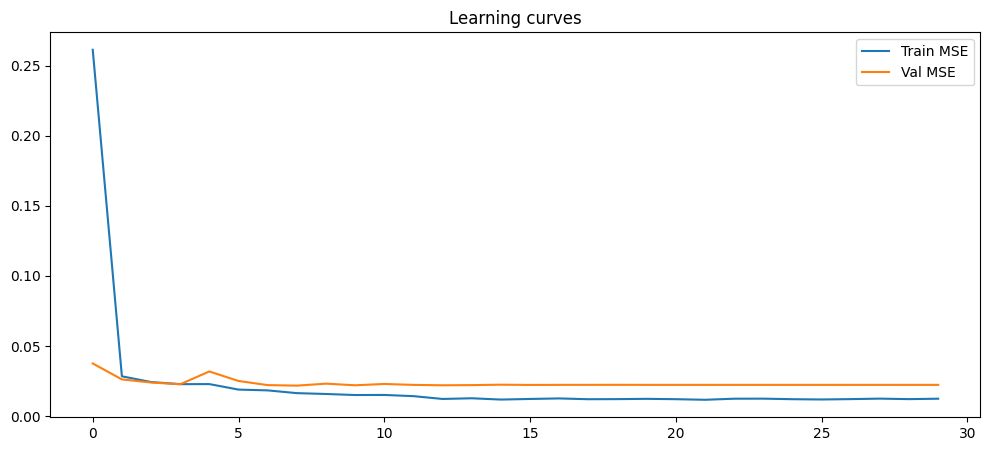

In [106]:
# Setup
from sklearn.metrics import mean_squared_error
model = StockLSTM(input_size=X_train.shape[2],
                  hidden_size=64,
                  num_layers=2,
                  output_size=1).to(device)
print("Number of parameter :")
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)
epochs = 30
train_losses, val_losses = [], []

for epoch in range(1, epochs+1):
    # --- Training ---
    model.train()
    total_loss = 0
    for Xb, yb in tqdm(train_loader, desc=f"Train {epoch}/{epochs}"):
        Xb, yb = Xb.to(device), yb.to(device).squeeze(-1)
        optimizer.zero_grad()
        preds = model(Xb).squeeze(-1)
        yb = yb.squeeze(-1)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    avg_train = total_loss / len(train_loader.dataset)
    train_losses.append(avg_train)

    # --- Validation ---
    model.eval()
    total_val, all_pred, all_true = 0, [], []
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb, yb = Xb.to(device), yb.to(device).squeeze(-1)
            preds = model(Xb).squeeze(-1)
            loss = criterion(preds, yb)
            total_val += loss.item() * Xb.size(0)
            all_pred.append(preds.cpu().numpy())
            all_true.append(yb.cpu().numpy())
    avg_val = total_val / len(val_loader.dataset)
    val_losses.append(avg_val)
    scheduler.step(avg_val)

    # Report
    print(f"Epoch {epoch}, Train MSE: {avg_train:.6f}, Val MSE: {avg_val:.6f}")

# --- Testing & Metrics ---
model.eval()
all_pred, all_true = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        Xb, yb = Xb.to(device), yb.to(device).squeeze(-1)
        p = model(Xb).squeeze(-1)
        all_pred.append(p.cpu().numpy())
        all_true.append(yb.cpu().numpy())

all_pred = np.concatenate(all_pred)
all_true = np.concatenate(all_true)
# If you scaled your y, inverse transform here:
# all_pred = target_scaler.inverse_transform(all_pred.reshape(-1,1)).flatten()
# all_true = target_scaler.inverse_transform(all_true.reshape(-1,1)).flatten()

mse = mean_squared_error(all_true, all_pred)
print(f"Test MSE: {mse:.4f}")

# --- Plots ---
plt.figure(figsize=(12,5))
plt.plot(train_losses, label='Train MSE')
plt.plot(val_losses, label='Val MSE')
plt.legend(); plt.title('Learning curves')
plt.show()


Testing:   0%|          | 0/12 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([16, 1, 1])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([12, 1, 1])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Testing: 100%|██████████| 12/12 [00:00<00:00, 977.24it/s]

Test Loss (MSE): 0.0453

Normalized Metrics:
RMSE: 0.1118
MAE: 0.0846
R²: 0.8544

Denormalized Metrics (USD):
RMSE: $1.22 (3.2% of mean price)
MAE: $0.93
MAPE (>$5 prices): 1.84%


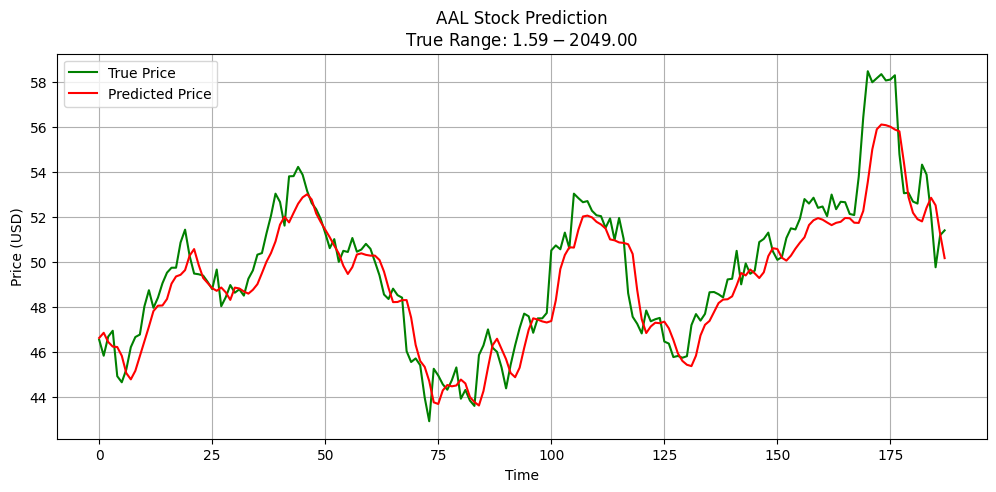

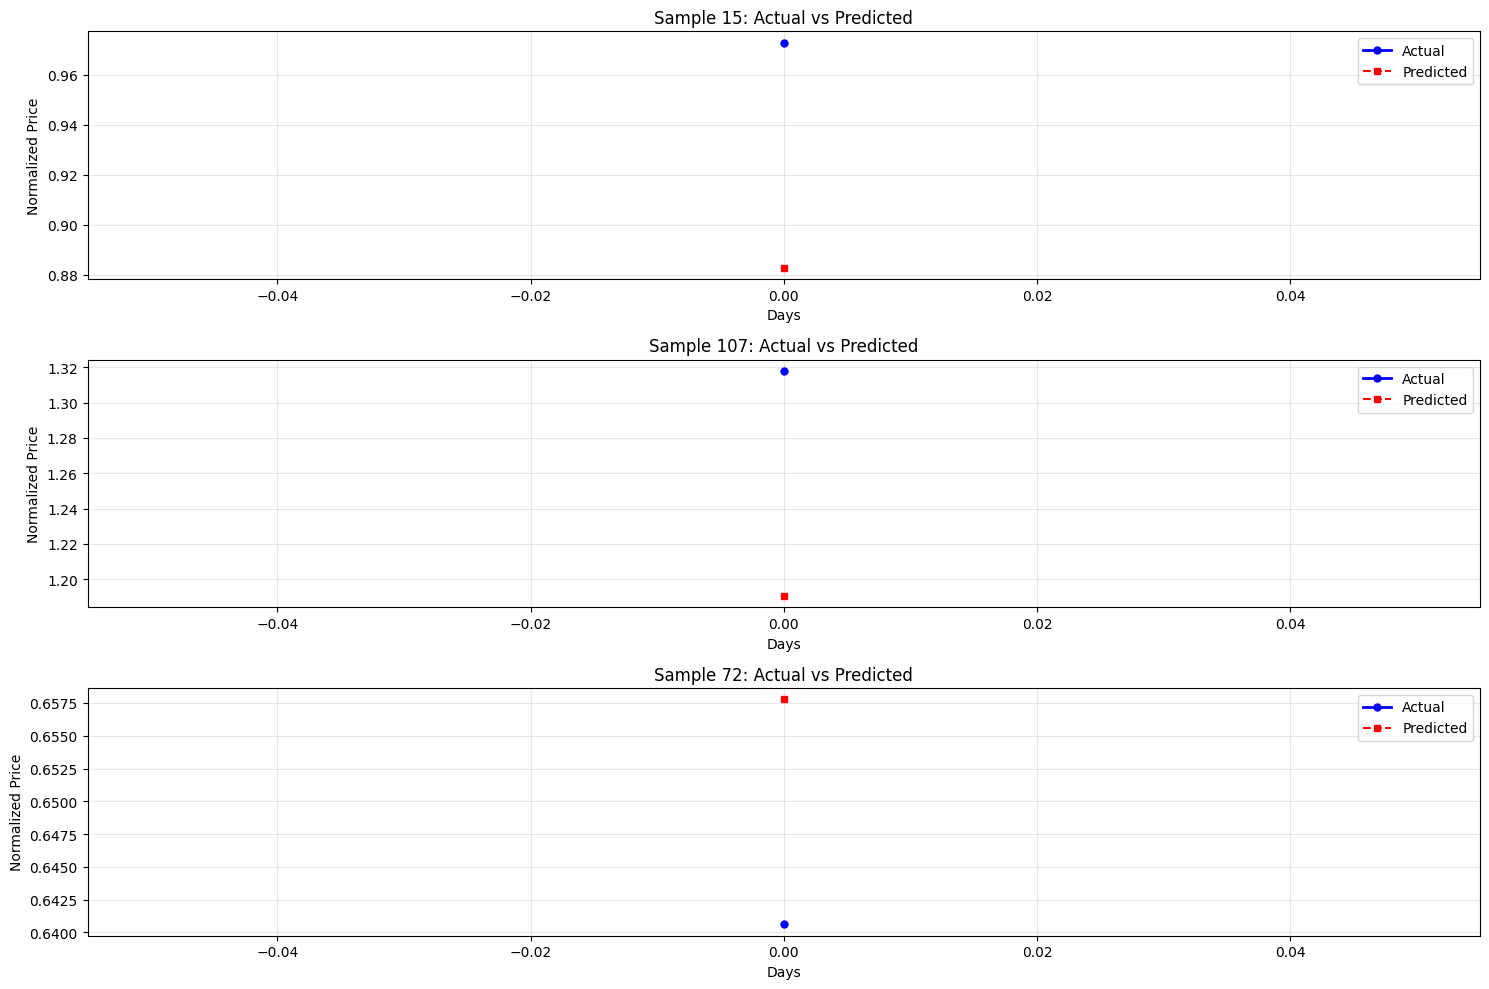

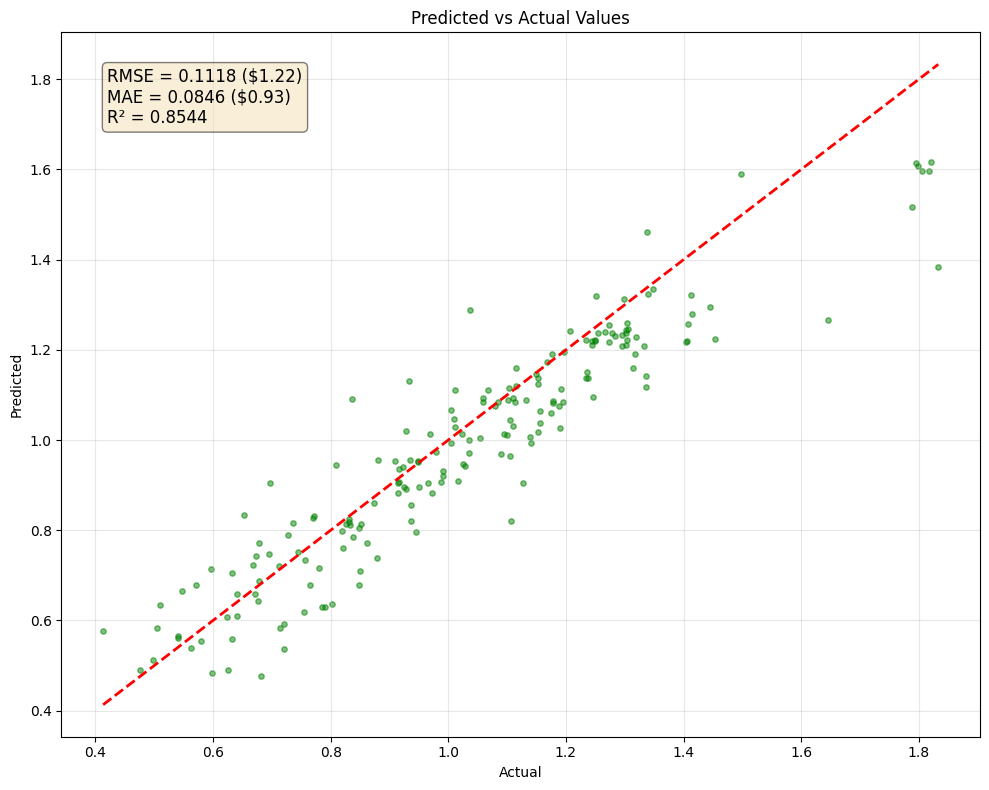

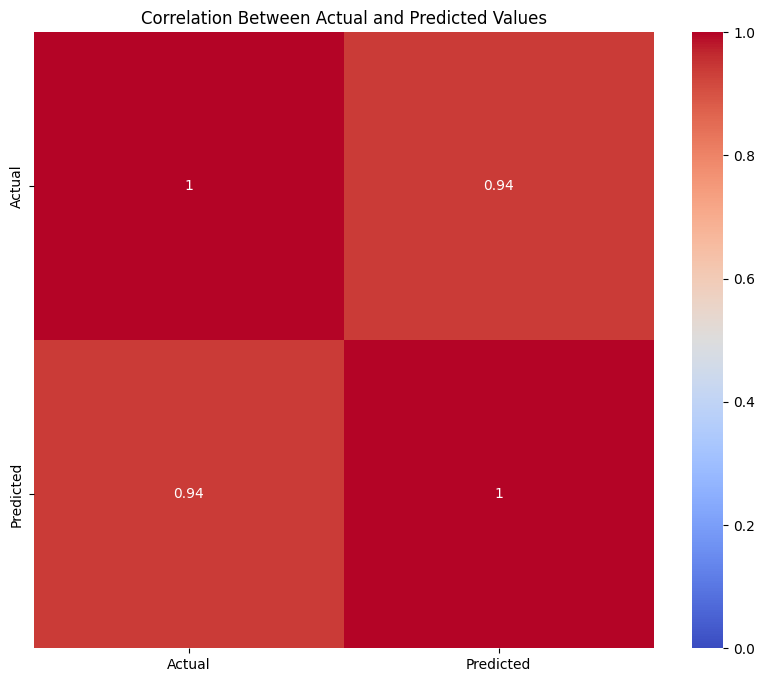

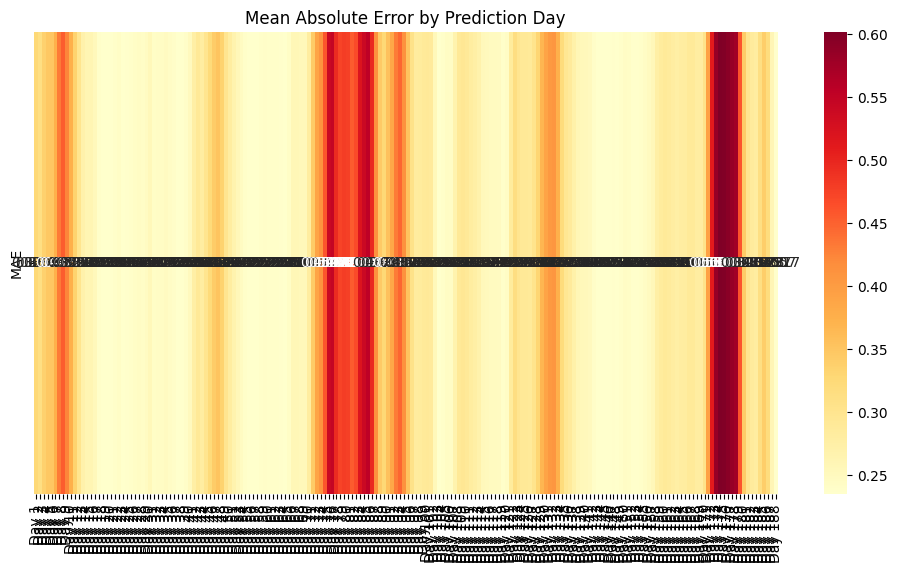

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


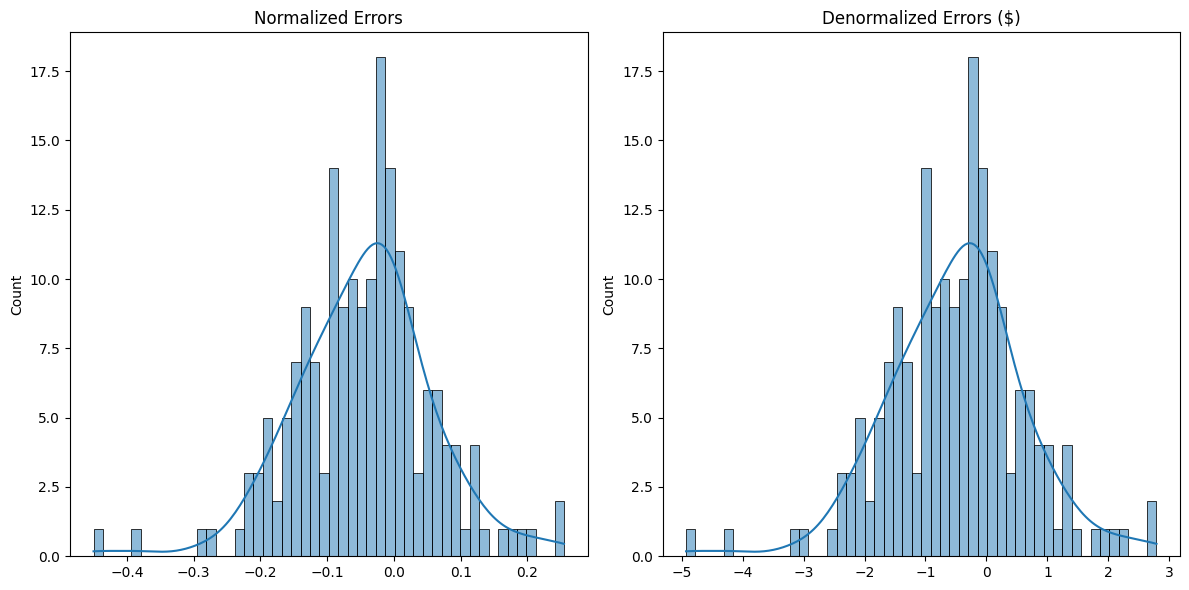

In [107]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm
import torch
import joblib

model.eval()

all_predictions = []
all_ground_truth = []
total_test_loss = 0

with torch.no_grad():
    for x_batch, y_batch in tqdm(test_loader, desc="Testing"):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        preds = model(x_batch)  # directly call model

        loss = criterion(preds, y_batch)
        total_test_loss += loss.item() * x_batch.size(0)

        all_predictions.append(preds.cpu().numpy())
        all_ground_truth.append(y_batch.cpu().numpy())

avg_test_loss = total_test_loss / len(test_loader.dataset)

all_predictions = np.concatenate(all_predictions, axis=0)
all_ground_truth = np.concatenate(all_ground_truth, axis=0)

y_true = all_ground_truth.flatten()
y_pred = all_predictions.flatten()

# Metrics
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

# Denormalization
target_scaler = joblib.load('target_scaler.pkl')
original_std = target_scaler.scale_[0]
original_mean = target_scaler.mean_[0]
y_true_denorm = (y_true * original_std) + original_mean
y_pred_denorm = (y_pred * original_std) + original_mean

rmse_denorm = np.sqrt(mean_squared_error(y_true_denorm, y_pred_denorm))
mae_denorm = mean_absolute_error(y_true_denorm, y_pred_denorm)

# Improved MAPE calculation (ignore prices < $5 to avoid extreme percentages)
valid_mask = y_true_denorm > 5.0
mape_denorm = np.mean(np.abs((y_true_denorm[valid_mask] - y_pred_denorm[valid_mask]) / 
                         y_true_denorm[valid_mask])) * 100
print(f"Test Loss (MSE): {avg_test_loss:.4f}")
print(f"\nNormalized Metrics:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

print(f"\nDenormalized Metrics (USD):")
print(f"RMSE: ${rmse_denorm:.2f} ({(rmse_denorm/original_mean)*100:.1f}% of mean price)")
print(f"MAE: ${mae_denorm:.2f}")
print(f"MAPE (>$5 prices): {mape_denorm:.2f}%")
# Plotting with USD values
plt.figure(figsize=(12, 5))
plt.plot(y_true_denorm, label="True Price", color='green')
plt.plot(y_pred_denorm, label="Predicted Price", color='red')
plt.title(f"AAL Stock Prediction\nTrue Range: ${df['close'].min():.2f}-${df['close'].max():.2f}")
plt.xlabel("Time")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()
## Visualization
try:
    # Plot 1: Time-series comparison
    plt.figure(figsize=(15, 10))
    for i in range(3):
        idx = np.random.randint(0, len(all_predictions))
        plt.subplot(3, 1, i+1)
        plt.plot(all_ground_truth[idx], 'b-o', label='Actual', linewidth=2, markersize=5)
        plt.plot(all_predictions[idx], 'r--s', label='Predicted', linewidth=1.5, markersize=5)
        plt.title(f"Sample {idx+1}: Actual vs Predicted")
        plt.xlabel("Days")
        plt.ylabel("Normalized Price")
        plt.grid(alpha=0.3)
        plt.legend()
    plt.tight_layout()
    plt.savefig('time_series_comparison.png', dpi=300)
    plt.show()

    # Plot 2: Scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(y_true, y_pred, alpha=0.5, c='green', s=15)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', linewidth=2)
    plt.title("Predicted vs Actual Values")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(alpha=0.3)
    
    textstr = '\n'.join((
    f'RMSE = {rmse:.4f} (${rmse_denorm:.2f})',
    f'MAE = {mae:.4f} (${mae_denorm:.2f})',
    f'R² = {r2:.4f}'
     ))

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.gca().text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
                  fontsize=12, verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.savefig('scatter_plot.png', dpi=300)
    plt.show()
    
    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = np.corrcoef(y_true, y_pred)
    sns.heatmap(correlation_matrix, annot=True, 
            xticklabels=['Actual', 'Predicted'], 
            yticklabels=['Actual', 'Predicted'],
            cmap='coolwarm', vmin=0, vmax=1)
    plt.title('Correlation Between Actual and Predicted Values')
    plt.show() 

    # Calculate absolute errors for each prediction day
    abs_errors = np.abs(all_predictions - all_ground_truth)
    mean_errors_by_day = np.mean(abs_errors, axis=0)

    plt.figure(figsize=(12, 6))
    sns.heatmap(mean_errors_by_day.reshape(1, -1), 
            annot=True, fmt=".4f",
            cmap="YlOrRd",
            xticklabels=[f"Day {i+1}" for i in range(mean_errors_by_day.shape[0])],
            yticklabels=['MAE'])
    plt.title('Mean Absolute Error by Prediction Day')
    plt.show()
    # Plot 3: Error distribution
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    errors_norm = y_pred - y_true
    sns.histplot(errors_norm, kde=True, bins=50)
    plt.title('Normalized Errors')
    
    plt.subplot(1, 2, 2)
    errors_denorm = y_pred_denorm - y_true_denorm
    sns.histplot(errors_denorm, kde=True, bins=50)
    plt.title('Denormalized Errors ($)')
    
    plt.tight_layout()
    plt.savefig('error_distribution.png', dpi=300)
    plt.show()

except Exception as e:
    print(f"Error generating plots: {str(e)}")